In [1]:
import networkx as nx
import warnings
import datetime
import seaborn as sn
sn.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from ast import literal_eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
herbest = pd.read_csv('../../Data/20190403/Datalab_Rit_Herkomst_Bestemming_Uur_20190403.csv', sep=';')

In [3]:
# List of all stations in the sub-network
stations = ['Amsteldijk','Amstelstation','Amstelveenseweg','Beethovenstraat','Bullewijk','Burg.de Vlugtlaan', 
    'Centraal Station','Cornelis Troostplein','Dam','De Boelelaan/VU','De Pijp','Europaplein',
    'Gaasperplas','Gein','Gerrit v.d. Veenstraat','Heemstedestraat','Henk Sneevlietweg','IJsbaanpad', 
    'Isolatorweg','Jan v.Galenstraat','Keizersgracht','Koningsplein','Kraaienneststation','Leidseplein',
    'Maasstraat','Marie Heinekenplein','Minervaplein','Muntplein','Museumplein','Nieuwezijds Kolk',
    'Nieuwmarkt','Noord','Noorderpark','Olympiaplein','Olympiaweg','Olympisch stadion','Overamstel', 
    'Postjesweg','Prinsengracht','Reigersbos','Rijksmuseum','Roelof Hartplein','Rokin','Scheldestraat',
    'Spaklerweg','Spui','Station Bijlmer ArenA','Station Diemen-Zuid','Station Duivendrecht', 'Stadionweg'
    'Station Ganzenhoef','Station Holendrecht','Station Lelylaan','Station RAI','Station Sloterdijk', 
    'Strandvliet','Van Baerlestraat','Van der Madeweg','Venserpolder','Verrijn Stuartweg','Victorieplein', 
    'Vijzelgracht','VU medisch centrum','Waalstraat','Waterlooplein','Weesperplein','Wibautstraat','Station Zuid']

In [4]:
stopdict = {'ITW': 1, 'GN': 1, 'RAI': 1, 'VSW': 1, 'ND': 1, 'RKN': 1, 
            'WPP': 1, 'RGB': 1, 'HVW': 1, 'OAS': 1, 'CLL': 1, 'PJW': 1, 
            'BLW': 1, 'WBS': 1, 'HLD': 1, 'MDW': 1, 'SVT': 1, 'DMZ': 1, 
            'BMR': 1, 'EPP': 1, 'WTC': 1, 'DPP': 1, 'JLS': 1, 'DVD': 1, 
            'GZH': 1, 'NDP': 1, 'NMT': 1, 'VLN': 1, 'ASA': 1, 'KEN': 1, 
            'VPD': 1, 'SLW': 1, 'WLP': 1, 'HDS': 1, 'GPP': 1, 'VZG': 1, 
            'CS': 1, 'VU': 1, 'ASW': 1, 'STD': 1, '08070': 1, '09122': 1, 
            '09121': 1, '07094': 1, '07091': 1, '08071': 1, '09013': 1, 
            '07004': 1, '08076': 1, '08078': 1, '07307': 1, '07308': 1, 
            '07120': 2, '07108': 2, '09083': 2, '09082': 2, '07202': 2, 
            '07121': 2, '09078': 2, '09079': 2, '07084': 2, '07083': 2, 
            '07207': 2, '07205': 2, '07017': 2, '07303': 2, '07350': 2, 
            '09074': 2, '09075': 2, '07098': 2, '07097': 2, '07493': 2, 
            '07490': 2, '09119': 2, '09120': 2, '05036': 3, '05035': 3, 
            '06072': 3, '06071': 3, '06075': 3, '06076': 3, '06073': 3, 
            '06074': 3, '07015': 3, '09049': 3, '09051': 3, '05062': 3, 
            '05061': 3, '07006': 3, '07007': 3, '07322': 3, '07321': 3, 
            '07323': 3, '07324': 3, '06067': 3, '05063': 3, '05032': 3, 
            '05031': 3, '07016': 0.6666666666666666, '09114': 0.6666666666666666, 
            '09111': 0.6666666666666666, '09139': 4, '09140': 4, '05022': 4, 
            '05011': 5, '06089': 5, '05065': 5, '05070': 5, '05069': 5}

#### Formatting for date and day of week

In [5]:
herbest['Datum'] = herbest['Datum'].apply(lambda x: datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S'))
herbest['Weekdag'] = herbest['Datum'].apply(lambda x: x.isoweekday())
herbest = herbest[(herbest['Datum'] >= datetime.datetime(2018, 8, 6)) &
                 (herbest['Datum'] < datetime.datetime(2019, 3, 25))]

#### Filter by hour and weekdays

In [6]:
herbest = herbest[herbest['UurgroepOmschrijving (van vertrek)'] == '08:00 - 08:59']
# herbest = herbest[herbest['Weekdag'].isin([6])]
herbest = herbest[herbest['Weekdag'].isin([1, 2, 3, 4])]

#### Filter by correct stops and normalize for different lines

In [7]:
herbest = herbest[(herbest['AankomstHalteNaam'].isin(stations))]
herbest = herbest[(herbest['VertrekHalteNaam'].isin(stations))]

In [8]:
herbest = herbest[herbest['VertrekHalteCode'].isin(stopdict.keys())]
herbest = herbest[herbest['AankomstHalteCode'].isin(stopdict.keys())]
herbest = herbest[herbest['AankomstHalteNaam'] != herbest['VertrekHalteNaam']]

In [9]:
herbest['AantalLijnenVertrek'] = herbest['VertrekHalteCode'].map(stopdict)
herbest['AantalLijnenAankomst'] = herbest['AankomstHalteCode'].map(stopdict)
herbest['AantalLijnen'] = np.where(herbest.AantalLijnenVertrek > herbest.AantalLijnenAankomst, 
         herbest.AantalLijnenAankomst, herbest.AantalLijnenVertrek)

In [10]:
herbest['AantalRittenNorm'] = herbest['AantalRitten']/herbest['AantalLijnen']

In [11]:
herbest.head(5)

,Datum,UurgroepOmschrijving (van vertrek),VertrekHalteCode,VertrekHalteNaam,VertrekLat,VertrekLon,AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalRitten,Weekdag,AantalLijnenVertrek,AantalLijnenAankomst,AantalLijnen,AantalRittenNorm
4626756,2018-08-06 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05062,Spui,4.889259,52.369097,84,1,5.0,3.0,3.0,28.000000
4626757,2018-08-06 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05065,Dam,4.890794,52.373678,118,1,5.0,5.0,5.0,23.600000
4626758,2018-08-06 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,05070,Nieuwezijds Kolk,4.892841,52.375754,29,1,5.0,5.0,5.0,5.800000
4626766,2018-08-06 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,06072,Prinsengracht,4.884284,52.364959,56,1,5.0,3.0,3.0,18.666667
4626767,2018-08-06 12:00:00,08:00 - 08:59,05011,Centraal Station,4.899218,52.378108,06074,Keizersgracht,4.886241,52.365884,57,1,5.0,3.0,3.0,19.000000


#### Create frequencies for all sub-trips from the data

In [12]:
datadict = {}
for index, row in herbest.iterrows():
    datadict[(row['VertrekHalteNaam'], row['AankomstHalteNaam'])] = row['AantalRittenNorm']

In [13]:
data = pd.DataFrame.from_dict(datadict, orient='index')
data = data.reset_index()
data.columns = ['stations', 'gvbtrips']

In [14]:
data.head()

,stations,gvbtrips
0,"(Centraal Station, Spui)",39.666667
1,"(Centraal Station, Dam)",26.000000
2,"(Centraal Station, Nieuwezijds Kolk)",10.000000
3,"(Centraal Station, Prinsengracht)",39.000000
4,"(Centraal Station, Keizersgracht)",37.000000


#### Get frequencies of sub-trips from simulations

In [16]:
simulation = pd.read_csv("../../Results/Sc1Week/8/odpairs.csv")
simulation = simulation.fillna(value=0)
simulation['average'] = simulation.mean(axis=1)
simulation = simulation[['stations', 'average']]
simulation.columns = ['stations', 'simulationtrips']
simulation['stations'] = simulation['stations'].apply(lambda x: literal_eval(x))

In [17]:
simulation.head()

,stations,simulationtrips
0,"(Amsteldijk, Amstelveenseweg)",0.0
1,"(Amsteldijk, Beethovenstraat)",0.0
2,"(Amsteldijk, Bullewijk)",0.0
3,"(Amsteldijk, Burg.de Vlugtlaan)",0.0
4,"(Amsteldijk, Centraal Station)",0.9


#### Combine simulation and gvb data, calculate error metrics

In [18]:
combined = data.merge(simulation, on='stations', how='outer')
combined = combined.fillna(value=0)
combined.head()

,stations,gvbtrips,simulationtrips
0,"(Centraal Station, Spui)",39.666667,16.0
1,"(Centraal Station, Dam)",26.000000,84.1
2,"(Centraal Station, Nieuwezijds Kolk)",10.000000,14.1
3,"(Centraal Station, Prinsengracht)",39.000000,11.2
4,"(Centraal Station, Keizersgracht)",37.000000,10.4


In [19]:
bothzero = combined[(combined['gvbtrips'] == 0) & (combined['simulationtrips'] == 0)].index
combined.drop(bothzero, inplace=True)

In [20]:
mean_absolute_error(combined['gvbtrips'], combined['simulationtrips'])

36.26289282836422

In [21]:
combined['difference'] = abs(combined['gvbtrips'] - combined['simulationtrips'])

In [24]:
combined = combined[(combined['difference'] < 20) & (combined['gvbtrips'] > 20)]
combined.sort_values(by='difference', ascending=False)

,stations,gvbtrips,simulationtrips,difference
539,"(Amstelstation, Cornelis Troostplein)",23.000000,3.5,19.500000
313,"(Wibautstraat, Centraal Station)",132.000000,112.8,19.200000
361,"(Station Zuid, Burg.de Vlugtlaan)",37.000000,17.9,19.100000
136,"(De Pijp, Europaplein)",77.000000,58.3,18.700000
257,"(Reigersbos, Amstelveenseweg)",28.000000,9.5,18.500000
592,"(Amstelstation, Maasstraat)",21.000000,2.5,18.500000
172,"(Heemstedestraat, Amstelveenseweg)",43.000000,25.2,17.800000
32,"(De Pijp, Amsteldijk)",22.500000,5.1,17.400000
272,"(Spaklerweg, Centraal Station)",33.000000,15.7,17.300000
255,"(Station RAI, Station Zuid)",38.000000,55.1,17.100000


#### Plot results

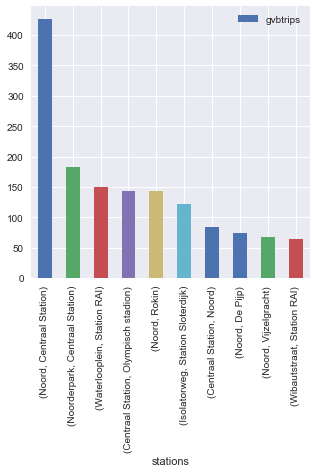

In [44]:
dataplot = (data.sort_values(by = 'gvbtrips', ascending = False)).head(10)
dataplot.plot(kind = 'bar', x = 'stations', y = 'gvbtrips', figsize = [5,5])

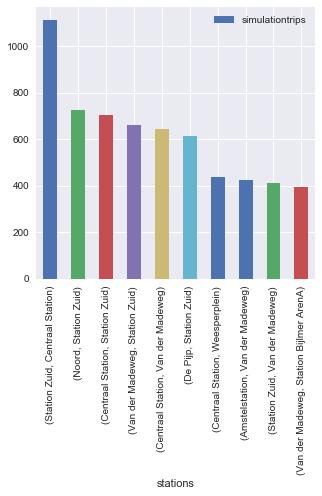

In [45]:
simulationplot = (simulation.sort_values(by = 'simulationtrips', ascending = False)).head(10)
simulationplot.plot(kind = 'bar', x = 'stations', y = 'simulationtrips', figsize = [5,5])